In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v6 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-01-09 19:26:21.361750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:21.362397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:21.411954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:21.412320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:21.412530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-09 19:26:21.414653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:21.414895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:21.415101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:22.021201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 19:26:22.021531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '005'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

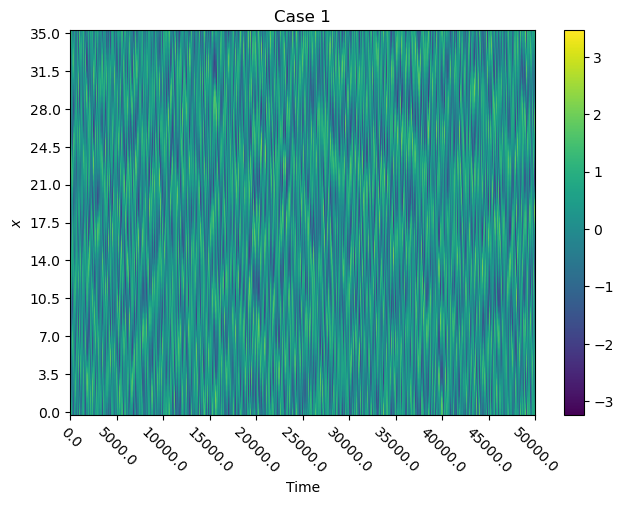

In [15]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, numpoints_xgrid), dtype=FTYPE)
        if normalization_type == 'stddev':
            for i in range(numpoints_xgrid):
                sample_mean = np.mean(all_data[:, i])
                sample_std = np.std(all_data[:, i])
                normalization_constant_arr_aedata[0, i] = sample_mean
                normalization_constant_arr_aedata[1, i] = stddev_multiplier*sample_std
        elif normalization_type == 'minmax':
            for i in range(numpoints_xgrid):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_aedata[0, i] = sample_min
                normalization_constant_arr_aedata[1, i] = sample_max - sample_min
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':ae_data_with_params,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
    time_stddev = time_stddev[0:numpoints_xgrid]
else:
    time_stddev[numpoints_xgrid:] = 1.0

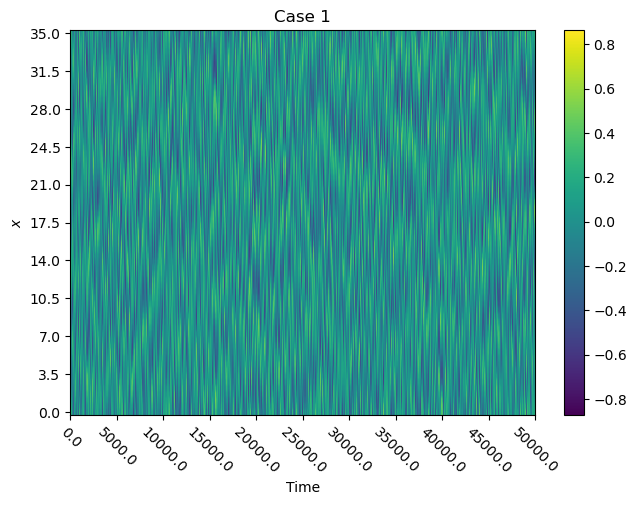

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [18]:
num_tsteps_to_take = 2

begin_idx = 0
for i in range(boundary_idx_arr.shape[0]):
    end_idx = boundary_idx_arr[i]
    num_samples = end_idx - begin_idx
    num_samples_new = int(num_samples) // num_tsteps_to_take
    
    end_idx_new = num_samples_new * num_tsteps_to_take
    
    difference_idx = end_idx - end_idx_new
    temp_idx = begin_idx+end_idx_new
    all_data[temp_idx:boundary_idx_arr[-1]-difference_idx] = all_data[begin_idx+end_idx:]
    
    boundary_idx_arr[i:] -= difference_idx
    all_data = all_data[0:boundary_idx_arr[-1]]

In [19]:
new_data = np.reshape(
    all_data,
    newshape=(
        int(all_data.shape[0]/num_tsteps_to_take),
        num_tsteps_to_take,
        all_data.shape[1]
    ),
    order='C'
)

In [20]:
all_data_og = all_data
all_data = new_data

In [21]:
boundary_idx_arr_og = boundary_idx_arr
boundary_idx_arr = boundary_idx_arr // num_tsteps_to_take

# Autoencoder

In [22]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 1/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev[0:numpoints_xgrid])
    contractive_lmda = 50
    dropout_rate = 0.01
    lmda_latentspace_dist = 0.01


    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'contractive_lmda':contractive_lmda,
        'dropout_rate':dropout_rate,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0
    try:
        contractive_lmda = tparams_dict['contractive_lmda']
    except:
        print("'contractive_lmda' not in tparams_dict, set to 0")
        contractive_lmda = 0.0
    try:
        dropout_rate = tparams_dict['dropout_rate']
    except:
        print("'dropout_rate' not in tparams_dict, set to 0")
        dropout_rate = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [23]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [24]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [25]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    latent_space_dim = 16
    enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
    # enc_layers = [192, 96, 48, 24, 12, 6, 3]
    # enc_layers = [96, 48, 24, 12, 6, 3]
    # enc_layers = [128, 64, 32, 16, 8, 4]
    # enc_layers = []
#     enc_layers = [32, 16, 8, 4]
    for i in range(len(enc_layers)):
        if latent_space_dim < enc_layers[-i-1]:
            enc_layers = enc_layers[0:-i]
            break
        if i == len(enc_layers)-1:
            enc_layers = []
    dec_layers = enc_layers[::-1]
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'linear'
    reg_name = 'L2'
    use_weights_post_dense = False
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=all_data.shape[-1],
                enc_layers=enc_layers,
                dec_layers=dec_layers,
                latent_space_dim=latent_space_dim,
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                contractive_lmda=contractive_lmda,
                dropout_rate=dropout_rate,
                use_weights_post_dense=use_weights_post_dense,)
    else:
        ae_net = Autoencoder(
            data_dim=all_data.shape[-1],
            enc_layers=enc_layers,
            dec_layers=dec_layers,
            latent_space_dim=latent_space_dim,
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            contractive_lmda=contractive_lmda,
            dropout_rate=dropout_rate,
            use_weights_post_dense=use_weights_post_dense,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=all_data.shape[-1], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=all_data.shape[-1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

In [26]:
from keras.engine import data_adapter

class AE_withTime(tf.keras.models.Model):
    def __init__(self, ae_net, lmda_latentspace_dist):
        super().__init__()
        self.ae_net = ae_net
        self.lmda_latentspace_dist = lmda_latentspace_dist
        self.beta_latentspace_dist = tf.Variable(
            initial_value=1.0,
            name='beta_latentspace_dist',
            trainable=True,
        )

    @tf.function
    def call(self, inputs, training=None):
        outputs = tf.keras.layers.TimeDistributed(self.ae_net.ae_net)(inputs, training=training)
        return outputs
        
    def train_step(self, data):

        # x, y = data
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)
        
        with tf.GradientTape() as tape1:
            ls_jacobian_norm = 0.0
            # encoded = []
            # for i in range(x.shape[1]):
            #     with tf.GradientTape() as tape2:
            #         encoded_i = self.ae_net.encoder_net(x[:, i, :], training=True)
            #     ls_jacobian_norm = ls_jacobian_norm + tf.norm(
            #         tape2.batch_jacobian(encoded_i, x[:, i, :]),
            #         ord='fro',
            #         axis=[-2, -1]
            #     )
            #     encoded.append(encoded_i)
            # ls_jacobian_norm = ls_jacobian_norm / x.shape[1]
            # encoded = tf.stack(encoded)
            # encoded = tf.transpose(encoded, perm=[1, 0, 2])

            encoded = tf.keras.layers.TimeDistributed(self.ae_net.encoder_net)(x, training=True)
            decoded = tf.keras.layers.TimeDistributed(self.ae_net.decoder_net)(encoded, training=True)
            
            x_norm = tf.norm(
                x[:, 1:, :] - x[:, 0:-1, :],
                ord='euclidean',
                axis=-1
            )
            ls_norm = tf.norm(
                encoded[:, 1:, :] - encoded[:, 0:-1, :],
                ord='euclidean',
                axis=-1
            )
            ls_dist_loss = tf.reduce_mean(tf.norm(ls_norm / x_norm - self.beta_latentspace_dist))
            loss = self.compiled_loss(
                y,
                decoded,
                sample_weight,
                regularization_losses=self.losses
            ) + self.ae_net.contractive_lmda*ls_jacobian_norm + self.lmda_latentspace_dist*ls_dist_loss

        self._validate_target_and_loss(decoded, loss)

        trainable_vars = self.trainable_variables
        gradients = tape1.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return self.compute_metrics(x, y, decoded, sample_weight, ls_jacobian_norm, ls_dist_loss, self.beta_latentspace_dist)
    
    def compute_metrics(self, x, y, decoded, sample_weight, ls_jacobian_norm=0.0, ls_dist_loss=0.0, beta_latentspace_dist=0.0):
        metric_results = super().compute_metrics(x, y, decoded, sample_weight)
        metric_results['ls_jacobian_norm'] = ls_jacobian_norm
        metric_results['ls_dist_loss'] = ls_dist_loss
        metric_results['beta_latentspace_dist'] = beta_latentspace_dist
        return metric_results

In [27]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [28]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

train_ls_jacobian_loss_hist = []
train_ls_dist_loss_hist = []
train_betals_hist = []

In [29]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [30]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev))]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    ae_t_net = AE_withTime(ae_net, lmda_latentspace_dist)
    ae_t_net.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
        loss=losses.MeanSquaredError(),
    #     loss=losses.BinaryCrossentropy(from_logits=False),
        run_eagerly=False,
        metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev))]
    )
    
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_t_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        train_ls_jacobian_loss_hist.append(history.history['ls_jacobian_norm'])
        train_ls_dist_loss_hist.append(history.history['ls_dist_loss'])
        
        train_betals_hist.append(history.history['beta_latentspace_dist'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
3125/3126 [============================>.] - ETA: 0s - loss: 0.0209 - mse: 0.0200 - NMSE: 0.1801 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 1.3471 - beta_latentspace_dist: 0.2810 - tot_time: 0h 0m 36.6s

Epoch 1: val_NMSE improved from inf to 0.08680, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 36s 11ms/step - loss: 0.0209 - mse: 0.0200 - NMSE: 0.1801 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 1.3463 - beta_latentspace_dist: 0.2808 - val_loss: 0.0106 - val_mse: 0.0096 - val_NMSE: 0.0868 - val_ls_jacobian_no

Epoch 11/1000
3124/3126 [============================>.] - ETA: 0s - loss: 0.0085 - mse: 0.0074 - NMSE: 0.0666 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1149 - beta_latentspace_dist: 0.0243 - tot_time: 0h 6m 11.2s

Epoch 11: val_NMSE did not improve from 0.04017
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 33s 10ms/step - loss: 0.0085 - mse: 0.0074 - NMSE: 0.0666 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1149 - beta_latentspace_dist: 0.0243 - val_loss: 0.0060 - val_mse: 0.0048 - val_NMSE: 0.0435 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 12/1000
3124/3126 [============================>.] - ETA: 0s - loss: 0.0084 - mse: 0.0073 - NMSE: 0.0654 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1142 - beta_latentspace_dist: 0.0242 - tot_time: 0h 6m 43.8s

Epoch 12: val_NMSE improved from 0.0

Epoch 22/1000
3121/3126 [============================>.] - ETA: 0s - loss: 0.0078 - mse: 0.0065 - NMSE: 0.0585 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1094 - beta_latentspace_dist: 0.0232 - tot_time: 0h 12m 10.4s

Epoch 22: val_NMSE did not improve from 0.03567
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 33s 11ms/step - loss: 0.0078 - mse: 0.0065 - NMSE: 0.0585 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1094 - beta_latentspace_dist: 0.0232 - val_loss: 0.0054 - val_mse: 0.0042 - val_NMSE: 0.0374 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 23/1000
3120/3126 [============================>.] - ETA: 0s - loss: 0.0077 - mse: 0.0065 - NMSE: 0.0581 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1098 - beta_latentspace_dist: 0.0234 - tot_time: 0h 12m 44.2s

Epoch 23: val_NMSE did not improve

Epoch 33/1000
3122/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 0.0062 - NMSE: 0.0559 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1093 - beta_latentspace_dist: 0.0232 - tot_time: 0h 18m 17.9s

Epoch 33: val_NMSE did not improve from 0.03000
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 34s 11ms/step - loss: 0.0075 - mse: 0.0062 - NMSE: 0.0559 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1092 - beta_latentspace_dist: 0.0232 - val_loss: 0.0058 - val_mse: 0.0044 - val_NMSE: 0.0400 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 34/1000
3124/3126 [============================>.] - ETA: 0s - loss: 0.0075 - mse: 0.0062 - NMSE: 0.0556 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1091 - beta_latentspace_dist: 0.0232 - tot_time: 0h 18m 51.5s

Epoch 34: val_NMSE did not improve

Epoch 44/1000
3126/3126 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0061 - NMSE: 0.0548 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1108 - beta_latentspace_dist: 0.0237 - tot_time: 0h 24m 19.2s

Epoch 44: val_NMSE did not improve from 0.02979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 32s 10ms/step - loss: 0.0075 - mse: 0.0061 - NMSE: 0.0548 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1107 - beta_latentspace_dist: 0.0237 - val_loss: 0.0049 - val_mse: 0.0036 - val_NMSE: 0.0322 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 45/1000
3124/3126 [============================>.] - ETA: 0s - loss: 0.0074 - mse: 0.0061 - NMSE: 0.0545 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1100 - beta_latentspace_dist: 0.0235 - tot_time: 0h 24m 52.1s

Epoch 45: val_NMSE improved from 0

Epoch 55/1000
3126/3126 [==============================] - ETA: 0s - loss: 0.0074 - mse: 0.0060 - NMSE: 0.0537 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1088 - beta_latentspace_dist: 0.0232 - tot_time: 0h 29m 14.7s

Epoch 55: val_NMSE did not improve from 0.02727
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0074 - mse: 0.0060 - NMSE: 0.0537 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1088 - beta_latentspace_dist: 0.0232 - val_loss: 0.0055 - val_mse: 0.0041 - val_NMSE: 0.0373 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 56/1000
3119/3126 [============================>.] - ETA: 0s - loss: 0.0074 - mse: 0.0060 - NMSE: 0.0537 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1096 - beta_latentspace_dist: 0.0232 - tot_time: 0h 29m 35.6s

Epoch 56: val_NMSE did not improve 

Epoch 66/1000
3121/3126 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0534 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1105 - beta_latentspace_dist: 0.0236 - tot_time: 0h 33m 27.8s

Epoch 66: val_NMSE did not improve from 0.02711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 24s 8ms/step - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0534 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1105 - beta_latentspace_dist: 0.0236 - val_loss: 0.0047 - val_mse: 0.0033 - val_NMSE: 0.0300 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 67/1000
3123/3126 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0532 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1099 - beta_latentspace_dist: 0.0234 - tot_time: 0h 33m 51.6s

Epoch 67: val_NMSE did not improve 

3124/3126 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0058 - NMSE: 0.0526 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1097 - beta_latentspace_dist: 0.0233 - tot_time: 0h 37m 47.2s

Epoch 77: val_NMSE did not improve from 0.02711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 24s 8ms/step - loss: 0.0073 - mse: 0.0058 - NMSE: 0.0526 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1097 - beta_latentspace_dist: 0.0233 - val_loss: 0.0052 - val_mse: 0.0038 - val_NMSE: 0.0342 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 78/1000
3123/3126 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0058 - NMSE: 0.0526 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1100 - beta_latentspace_dist: 0.0233 - tot_time: 0h 38m 10.4s

Epoch 78: val_NMSE did not improve from 0.02711
 

Epoch 4/1000
3126/3126 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0533 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1105 - beta_latentspace_dist: 0.0235 - tot_time: 0h 41m 52.2s

Epoch 4: val_NMSE did not improve from 0.02711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0533 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1105 - beta_latentspace_dist: 0.0235 - val_loss: 0.0048 - val_mse: 0.0034 - val_NMSE: 0.0306 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 5/1000
3126/3126 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0531 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1094 - beta_latentspace_dist: 0.0233 - tot_time: 0h 42m 13.3s

Epoch 5: val_NMSE did not improve from

3122/3126 [============================>.] - ETA: 0s - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0529 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1111 - beta_latentspace_dist: 0.0236 - tot_time: 0h 45m 45.6s

Epoch 15: val_NMSE did not improve from 0.02711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0529 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1111 - beta_latentspace_dist: 0.0236 - val_loss: 0.0056 - val_mse: 0.0042 - val_NMSE: 0.0379 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 16/1000
3126/3126 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0059 - NMSE: 0.0528 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1103 - beta_latentspace_dist: 0.0235 - tot_time: 0h 46m 6.7s

Epoch 16: val_NMSE did not improve from 0.02711
 -

3121/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0523 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1107 - beta_latentspace_dist: 0.0234 - tot_time: 0h 49m 41.8s

Epoch 26: val_NMSE did not improve from 0.02711
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 21s 7ms/step - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0523 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1106 - beta_latentspace_dist: 0.0234 - val_loss: 0.0046 - val_mse: 0.0032 - val_NMSE: 0.0290 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 27/1000
3120/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0522 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1104 - beta_latentspace_dist: 0.0234 - tot_time: 0h 50m 3.4s

Epoch 27: val_NMSE improved from 0.02711 to 0.0249

Epoch 37/1000
3125/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0520 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1098 - beta_latentspace_dist: 0.0232 - tot_time: 0h 53m 39.1s

Epoch 37: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0520 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1098 - beta_latentspace_dist: 0.0232 - val_loss: 0.0047 - val_mse: 0.0033 - val_NMSE: 0.0298 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 38/1000
3119/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0519 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1096 - beta_latentspace_dist: 0.0232 - tot_time: 0h 54m 0.4s

Epoch 38: val_NMSE did not improve f

3122/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0516 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1102 - beta_latentspace_dist: 0.0233 - tot_time: 0h 57m 36.8s

Epoch 48: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 22s 7ms/step - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0516 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1101 - beta_latentspace_dist: 0.0233 - val_loss: 0.0046 - val_mse: 0.0032 - val_NMSE: 0.0288 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 49/1000
3121/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0516 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1099 - beta_latentspace_dist: 0.0232 - tot_time: 0h 57m 58.7s

Epoch 49: val_NMSE did not improve from 0.02491
 

Epoch 7/1000
3119/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0521 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1101 - beta_latentspace_dist: 0.0233 - tot_time: 1h 1m 39.9s

Epoch 7: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 24s 8ms/step - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0521 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1101 - beta_latentspace_dist: 0.0233 - val_loss: 0.0049 - val_mse: 0.0034 - val_NMSE: 0.0309 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 8/1000
3125/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0521 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1104 - beta_latentspace_dist: 0.0233 - tot_time: 1h 2m 3.2s

Epoch 8: val_NMSE did not improve from 0.

3125/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0517 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1103 - beta_latentspace_dist: 0.0233 - tot_time: 1h 5m 57.4s

Epoch 18: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0517 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1102 - beta_latentspace_dist: 0.0233 - val_loss: 0.0054 - val_mse: 0.0040 - val_NMSE: 0.0358 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 19/1000
3123/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0058 - NMSE: 0.0519 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1105 - beta_latentspace_dist: 0.0233 - tot_time: 1h 6m 19.7s

Epoch 19: val_NMSE did not improve from 0.02491
 - 

3124/3126 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0515 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1100 - beta_latentspace_dist: 0.0231 - tot_time: 1h 10m 12.6s

Epoch 29: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0515 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1099 - beta_latentspace_dist: 0.0231 - val_loss: 0.0050 - val_mse: 0.0036 - val_NMSE: 0.0324 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 30/1000
3126/3126 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0516 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1110 - beta_latentspace_dist: 0.0234 - tot_time: 1h 10m 38.0s

Epoch 30: val_NMSE did not improve from 0.02491
 

3126/3126 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0515 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1104 - beta_latentspace_dist: 0.0233 - tot_time: 1h 14m 57.2s

Epoch 40: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 26s 8ms/step - loss: 0.0072 - mse: 0.0057 - NMSE: 0.0515 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1104 - beta_latentspace_dist: 0.0233 - val_loss: 0.0047 - val_mse: 0.0033 - val_NMSE: 0.0296 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 41/1000
3125/3126 [============================>.] - ETA: 0s - loss: 0.0071 - mse: 0.0057 - NMSE: 0.0514 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1111 - beta_latentspace_dist: 0.0235 - tot_time: 1h 15m 22.2s

Epoch 41: val_NMSE did not improve from 0.02491
 

3121/3126 [============================>.] - ETA: 0s - loss: 0.0071 - mse: 0.0057 - NMSE: 0.0513 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1111 - beta_latentspace_dist: 0.0233 - tot_time: 1h 19m 22.3s

Epoch 51: val_NMSE did not improve from 0.02491
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_059/checkpoints/LossHistoriesCheckpoint
3126/3126 [==============================] - 23s 7ms/step - loss: 0.0071 - mse: 0.0057 - NMSE: 0.0513 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1110 - beta_latentspace_dist: 0.0233 - val_loss: 0.0058 - val_mse: 0.0044 - val_NMSE: 0.0395 - val_ls_jacobian_norm: 0.0000e+00 - val_ls_dist_loss: 0.0000e+00 - val_beta_latentspace_dist: 0.0000e+00
Epoch 52/1000
3123/3126 [============================>.] - ETA: 0s - loss: 0.0071 - mse: 0.0057 - NMSE: 0.0509 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.1109 - beta_latentspace_dist: 0.0233 - tot_time: 1h 19m 45.4s

Epoch 52: val_NMSE did not improve from 0.02491
 

In [32]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_t_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_t_net.evaluate(training_data, training_data)
    val_metrics = ae_t_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'train_ls_jacobian_loss_hist':train_ls_jacobian_loss_hist,
            'train_ls_dist_loss_hist':train_ls_dist_loss_hist,
            'train_betals_hist':train_betals_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

782/782 [==============================] - 3s 4ms/step - loss: 0.0045 - mse: 0.0031 - NMSE: 0.0277 - ls_jacobian_norm: 0.0000e+00 - ls_dist_loss: 0.0000e+00 - beta_latentspace_dist: 0.0000e+00


In [33]:
print('lr_change : ', lr_change)

lr_change :  [0, 84, 136, 191]


In [34]:
temp = []
for lst in train_ls_dist_loss_hist:
    temp.extend(lst)
train_ls_dist_loss_hist_og = train_ls_dist_loss_hist
train_ls_dist_loss_hist = np.array(temp)

temp = []
for lst in train_ls_jacobian_loss_hist:
    temp.extend(lst)
train_ls_jacobian_loss_hist_og = train_ls_jacobian_loss_hist
train_ls_jacobian_loss_hist = np.array(temp)

temp = []
for lst in train_betals_hist:
    temp.extend(lst)
train_betals_hist_og = train_betals_hist
train_betals_hist = np.array(temp)

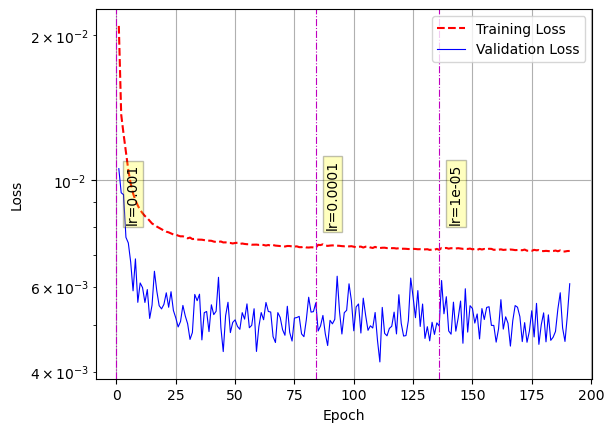

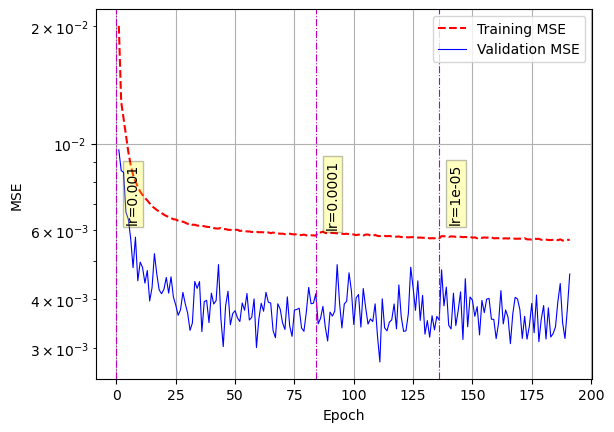

<Figure size 640x480 with 0 Axes>

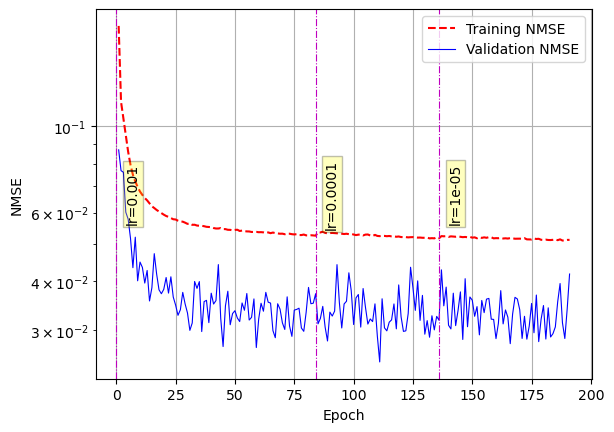

<Figure size 640x480 with 0 Axes>

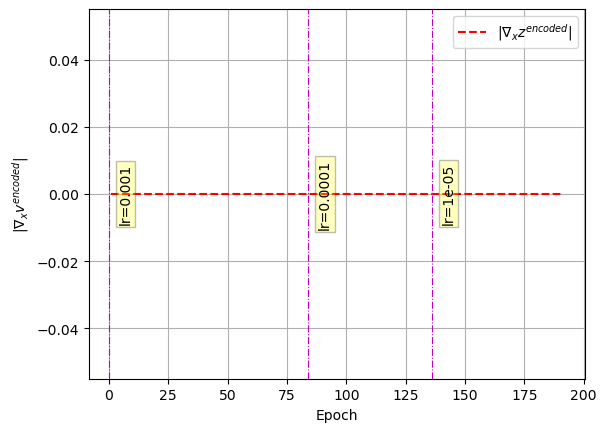

<Figure size 640x480 with 0 Axes>

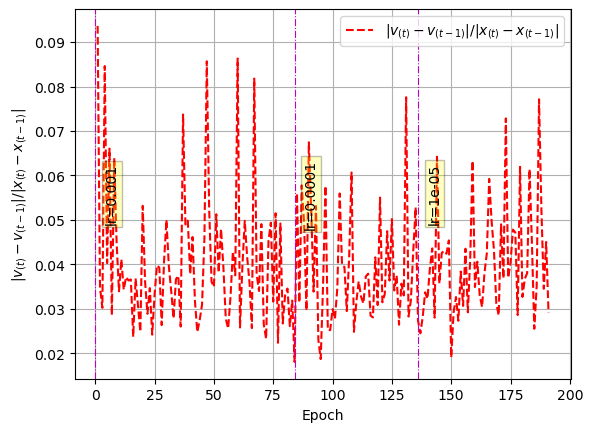

<Figure size 640x480 with 0 Axes>

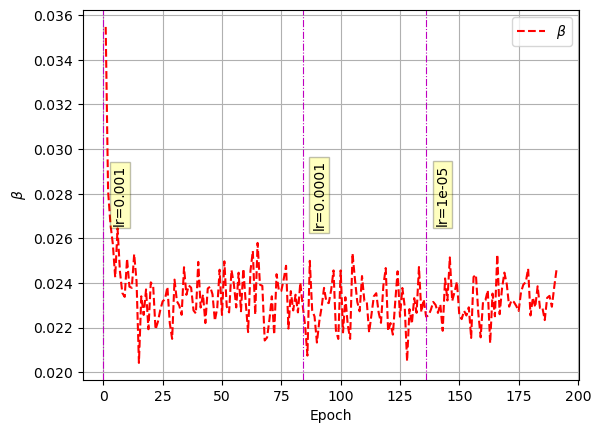

<Figure size 640x480 with 0 Axes>

In [36]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_ls_jacobian_loss_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\| \nabla_{x} z^{encoded} \|$"],
    xlabel='Epoch',
    ylabel=r"$\| \nabla_{x} v^{encoded} \|$",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_ls_jacobian_loss_hist.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_ls_dist_loss_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$|v_{(t)} - v_{(t-1)}| / |x_{(t)} - x_{(t-1)}|$"],
    xlabel='Epoch',
    ylabel=r"$|v_{(t)} - v_{(t-1)}| / |x_{(t)} - x_{(t-1)}|$",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_ls_dist_loss_hist.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_betals_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"$\beta$"],
    xlabel='Epoch',
    ylabel=r"$\beta$",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_betals_hist.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [37]:
reconstructed_data = ae_net.predict(all_data_og)

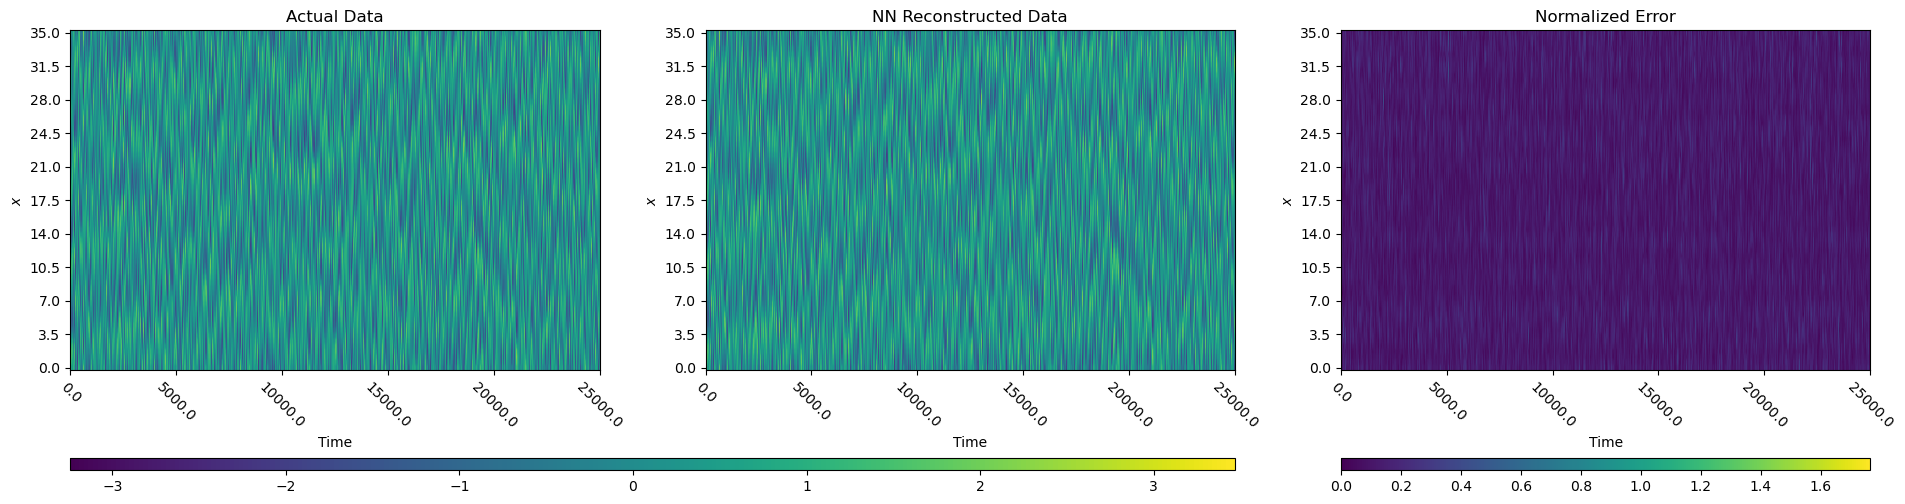

In [38]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data_og,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [39]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data_og,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [40]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data_og)

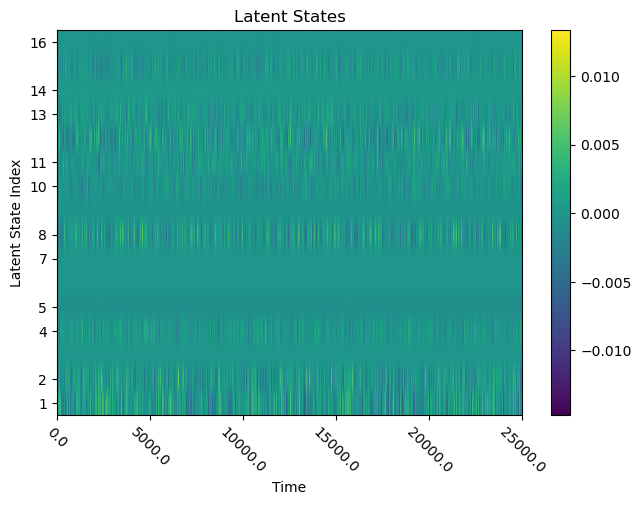

In [41]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=False)

In [42]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [43]:
# ae_net.summary()

In [53]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = latent_states_all.shape[-1]
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(num_rows, num_cols, sharex=True, figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    for j in range(latent_states_all.shape[-1]):
        ax[j].plot(input_time, latent_states_all[prev_idx:next_idx, j])
        # ax[j].plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
        # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
        # print(xticks)
        # ax[j].set_xticks(ticks=np.round(xticks*delta_t, 1))
        # ax[j].set_xticklabels('')
        ax[j].tick_params(axis='x', rotation=270+45)
        ax[j].set_ylabel('latent state {}'.format(j+1))
        ax[j].set_xlabel(r'Time$^+$')
        ax[j].grid(True)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    # ax[-1].set_xlabel(r'Time$^+$')
    # ax[0].legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax[0].title.set_text(r'Case '+str(i+1))

    if save_dir is not None:
        fig.savefig(dir_name_plot+'/LatentSpace-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = boundary_idx_arr[i]

# KE and Dissipation

In [44]:
save_dir = dir_name_ae+dir_sep+'plots'
# save_dir = None

In [45]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data_og[:, 0:xgrid.shape[0]]#.copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]#.copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data_og[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)
    
    print('Case {} - KE_nrmse : {}'.format(i+1, KE_rmse_normalized))

    begin_idx = boundary_idx_arr[i]

Case 1 - KE_nrmse : 0.11781539432322538


In [46]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    # prev_idx = boundary_idx_arr[i] - (next_idx-prev_idx)
    # next_idx = boundary_idx_arr[i]
    
    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [47]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [48]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    print('Case {} - D_nrmse : {}'.format(i+1, D_rmse_normalized))
    
    begin_idx = boundary_idx_arr[i]

Case 1 - D_nrmse : 0.1652004145355862


In [49]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [50]:
np.savez(
    dir_name_ae+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)

In [51]:
# x = np.linspace(-5, 5, 100)

# a = 1 #- np.exp(-2)

# modified_relu = lambda x : tf.keras.activations.relu(x+a).numpy()-a
# elu = lambda x : tf.keras.activations.elu(x)

# y1 = modified_relu(x)
# y2 = elu(x)

# plt.plot(x, y1, label='modified_relu')
# plt.plot(x, y2, label='elu')
# plt.legend()
# plt.grid(True)
# plt.show()

In [52]:
ae_net.decoder_layers_list[-1].weights

[<tf.Variable 'dense_15/kernel:0' shape=(128, 64) dtype=float32, numpy=
 array([[ 1.5893335e-03,  3.4049308e-04, -7.6095144e-05, ...,
         -6.4764344e-03, -5.7157869e-03, -6.8439142e-04],
        [ 7.6440796e-02,  8.4021568e-02,  4.6753168e-02, ...,
         -1.1689108e-03,  1.4681874e-02,  4.4126328e-02],
        [ 3.4593877e-03,  3.0576321e-03,  5.6160190e-03, ...,
          1.1359313e-02,  9.1779707e-03,  6.1338376e-03],
        ...,
        [-1.6019674e-02, -1.6034672e-02, -1.2868359e-02, ...,
         -1.1404767e-02, -1.1056705e-02, -1.3422602e-02],
        [-1.9215718e-02, -1.3322487e-02, -8.2199331e-03, ...,
         -2.7030313e-02, -2.7483393e-02, -2.4462814e-02],
        [ 1.7083278e-03,  8.5158081e-04,  1.8482117e-04, ...,
         -2.5009764e-03,  4.2588043e-04,  1.8361796e-03]], dtype=float32)>,
 <tf.Variable 'dense_15/bias:0' shape=(64,) dtype=float32, numpy=
 array([-0.02418012, -0.01814753, -0.01117205, -0.00640705, -0.00360681,
         0.00066311,  0.00688108,  0.0